# 0.0 IMPORTS

In [174]:
import math
import datetime
import inflection
import random
import warnings
import pickle
from tabulate import tabulate

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats as ss
import matplotlib.pyplot as plt

from IPython.display import Image

import xgboost as xgb
from boruta import BorutaPy
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.rcParams['font.size'] = 30
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    
warnings.filterwarnings( 'ignore' )
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k - 1) * (r - 1) / (n - 1) )
    
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt((chi2corr/n) / (min( kcorr-1, rcorr-1 ) ) )

In [4]:
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0] )

In [5]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( f'\nKFold Number: {k}' )
        # Start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )

        # Filtering Dataset
        training = x_training[x_training['date'] < validation_start_date ]
        validation = x_training[( x_training['date'] >= validation_start_date ) & ( x_training['date'] <= validation_end_date )]

        # Training Dataset
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # Validation Dataset
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # Model
        m = model.fit( xtraining, ytraining )


        # Prediction
        yhat = m.predict( xvalidation )


        # Performance
        m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1(yhat) )

        # Store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name, 
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ), 
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ), 
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )

In [6]:
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

## 0.2 Loading Data

In [7]:
# Data load
df_sales_raw = pd.read_csv( '/home/jeffsmedines/repos/ds_producao_project/modulo_02/data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( '/home/jeffsmedines/repos/ds_producao_project/modulo_02/data/store.csv', low_memory=False )

# Data Merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0 STEP 01 - DATA DESCRIPTION

## 1.1 Rename Columns

In [8]:
df1 = df_raw.copy()

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',             'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
            'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# Cols Rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [10]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of cols: {df1.shape[1]}')

Number of rows: 1017209
Number of cols: 18


## 1.3 Data Types

In [11]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA's

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA's

In [13]:
# competition_distance
# Vamos assumir que os NA's dessa coluna representam que não existe um competidor próximo, e para indicar isso colocaremos uma distância muito maior que a máxima da coluna, como uma forma de introduzir um dado que mostra não ter competidor próximo.
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 2000000.0 if math.isnan( x ) else x )

# competition_open_since_month
# Existem ocorrências onde existe o dado da distância entre o competidor mais próximo mas não a data que ele iniciou, por isso iremos pegar a data da coluna date para preencher esses NA's pois o fator quanto tempo faz desde que um evento aconteceu é muito importante.
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

# promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

# promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna( 0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
df1['competition_distance'] = df1['competition_distance'].astype( int )

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                     int64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistics

In [17]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes 

In [18]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - Std, min, max, range, skewness, kurtosis.
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skewness', 'kurtosis']

In [19]:
m

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,2000000.0,1999980.0,10610.588099,2330.0,101810.649100,19.378002,375.644405
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [20]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

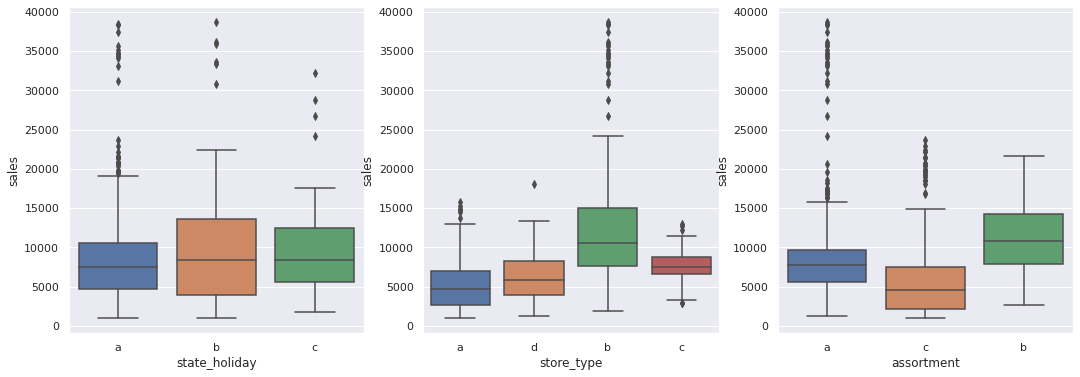

In [21]:
aux1 = df1[ ( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 ) ]

plt.figure(figsize=(18, 6))

plt.subplot( 131 )
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 132 )
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 133 )
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0 STEP 02 - FEATURE ENGINEERING

In [22]:
df2 = df1.copy()

## 2.1 Hypothesis Mindmap

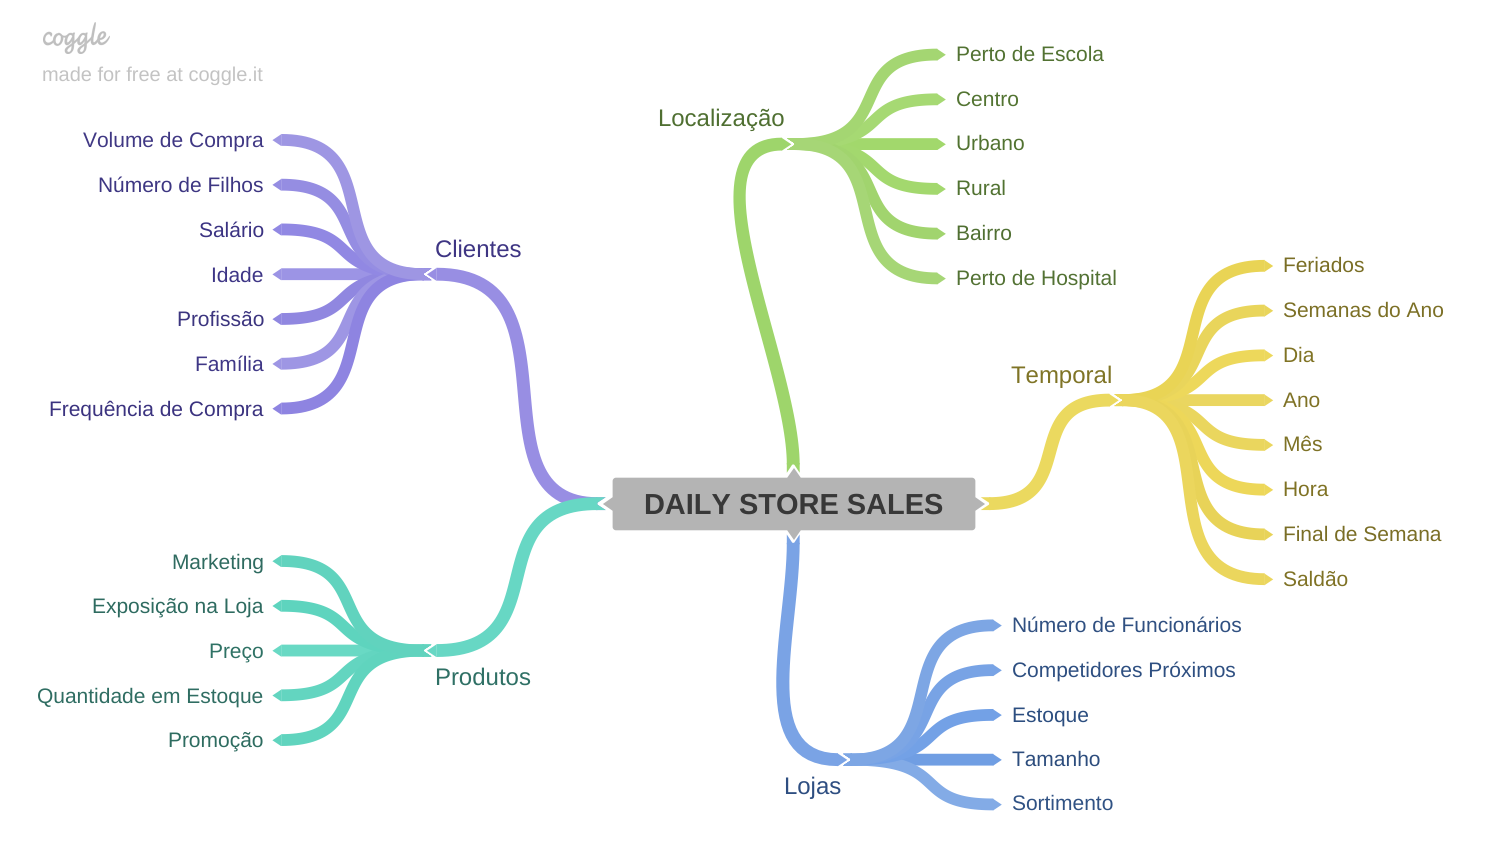

In [23]:
Image( '/home/jeffsmedines/repos/ds_producao/img/DAILY_STORE_SALES.png' )

## 2.2. Hypothesis Creating

### 2.2.1 Store Hypotheses

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam ender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.2.2 Product Hypotheses

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expõem mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores deveriam vender mais.

**4.** Lojas com promoções mais agressivas (maiores descontos) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Time Hypotheses

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de cada semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Hypotheses Final List

**1.** Lojas com maior sortimento deveriam ender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.



**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.



**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de cada semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [24]:
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of Year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Year Week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# Competitive since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'] , day=1 ), axis=1 )

df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int )

# Promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )

# Assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# State Holiday a = public holiday, b = Easter holiday, c = Christmas
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# 3.0 STEP 03 - FEATURE FILTERING

In [25]:
df3 = df2.copy()

## 3.1 Row Filtering

In [26]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 ) ]

## 3.2 Columns Selection

In [27]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop( cols_drop, axis=1 )

In [28]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 STEP 04 - EXPLORATORY DATA ANALYSIS

In [29]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

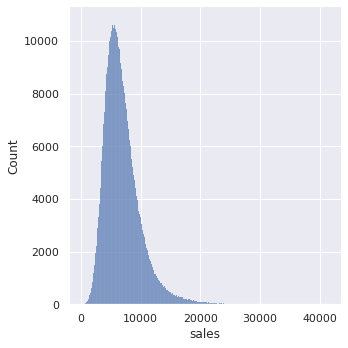

In [30]:
sns.displot( df4['sales'] );

### 4.1.2 Numerical Variable

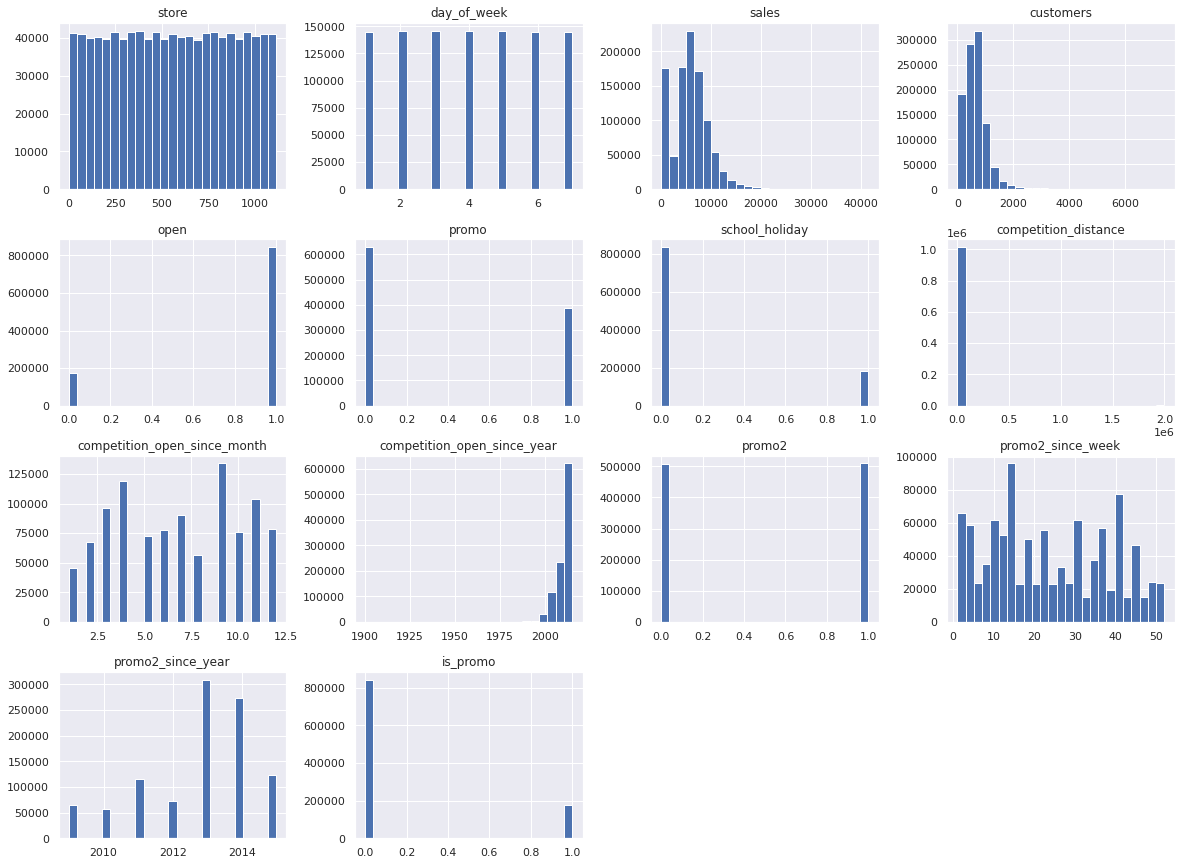

In [31]:
# num_attributes.hist( bins=25 );
num_attributes.hist( bins=25 );

In [32]:
# Exercício de casa, olhar cada um desses gráficos e fazer uma análise da skew e kurtosis e explicar por exemplo o q quer dizer ter ou nao skew/kurtosis

### 4.1.3 Categorical Variable

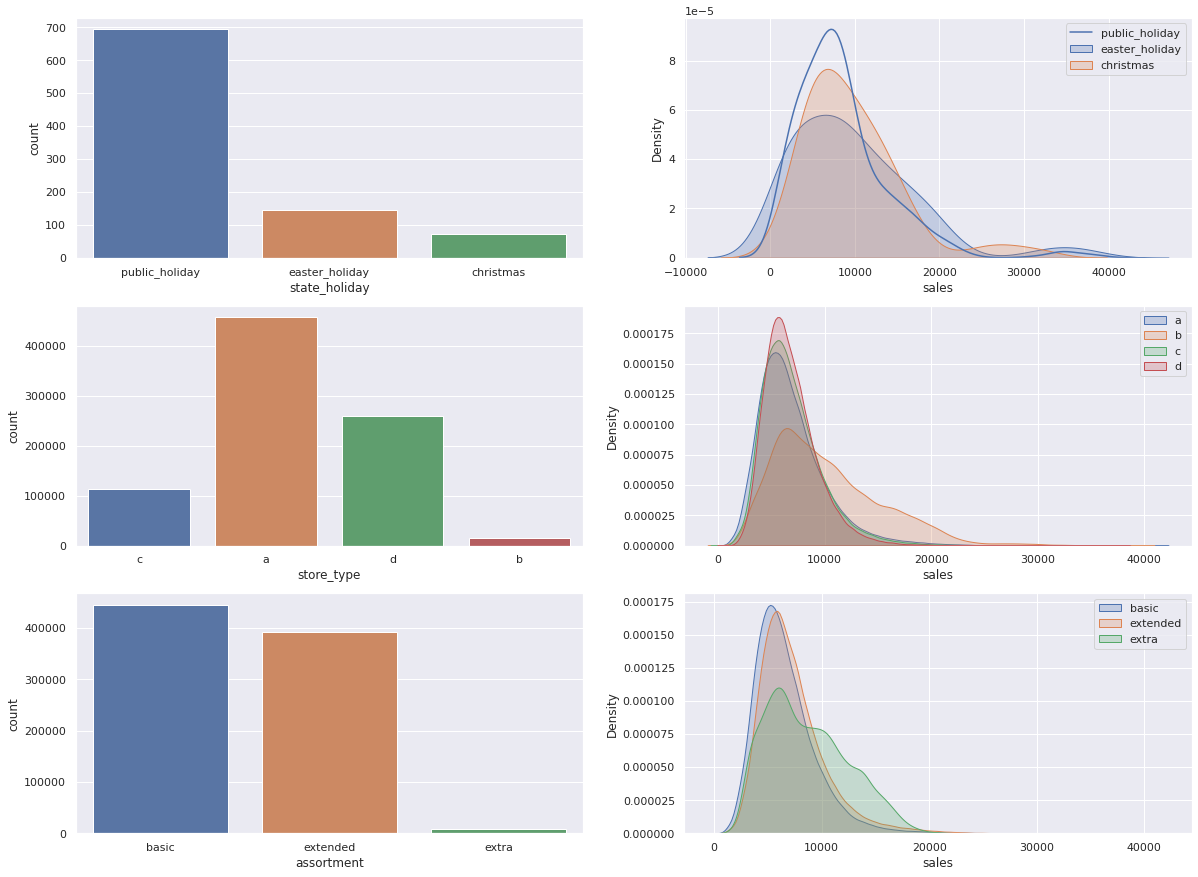

In [33]:
# State Holiday
plt.subplot( 3, 2, 1 )

a = df4[df4['state_holiday'] != 'regular_day'] 
sns.countplot( x=a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=False )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )
plt.legend()

# Store Type
plt.subplot( 3, 2, 3 ) 
sns.countplot( x=df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )
plt.legend()

# Assortment
plt.subplot( 3, 2, 5 ) 
sns.countplot( x=df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )
plt.legend()

## 4.2 Bivariate Analysis

### **H1.** Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com maior sortimento vendem menos.

A variável possui muitos comportamentos sazonais e principalmente uma diferença brusca de volume em relação a categoria extra com as outras duas explicando dois tipos de comportamento (comportamente quase idêntico de basica e extended, e o comportamente extremamente diferente da categoria extra), tendo por consequência muita informação e sendo assim, importante para o modelo.

<AxesSubplot:xlabel='year_week'>

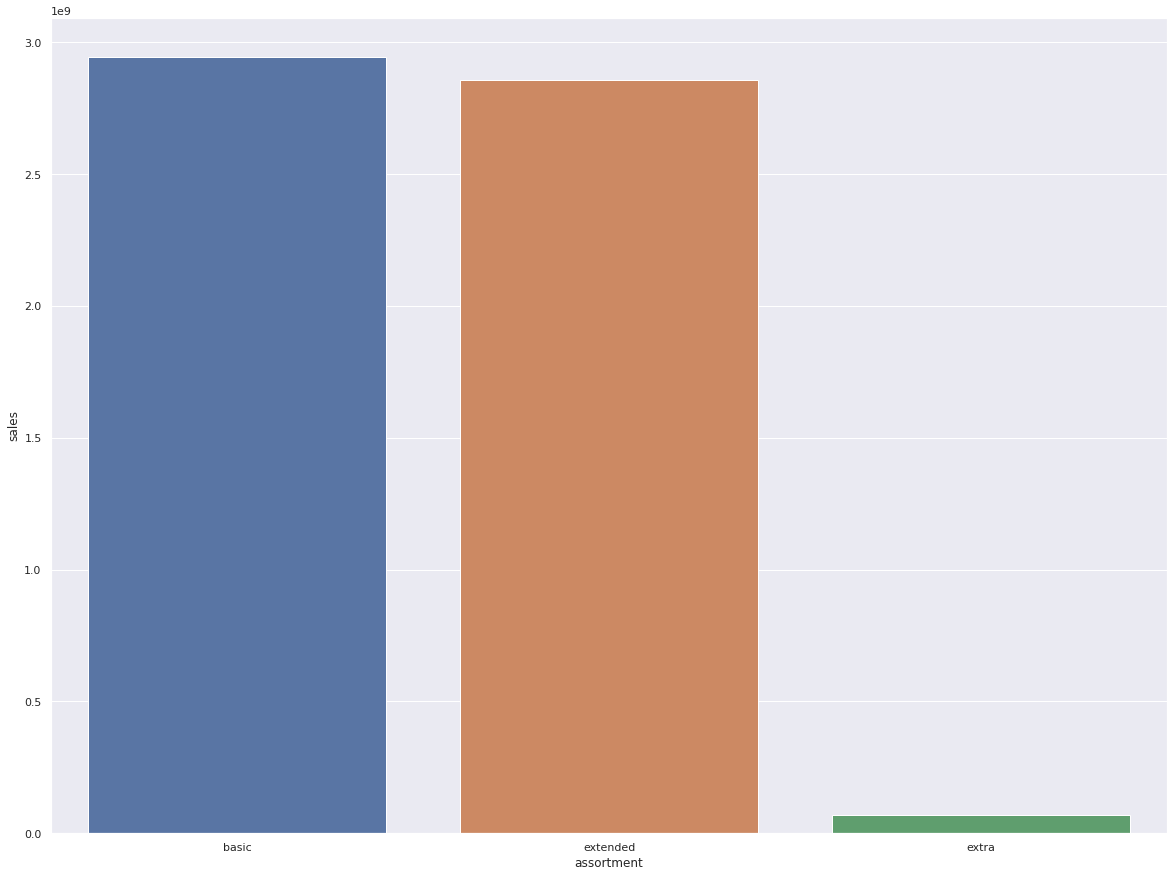

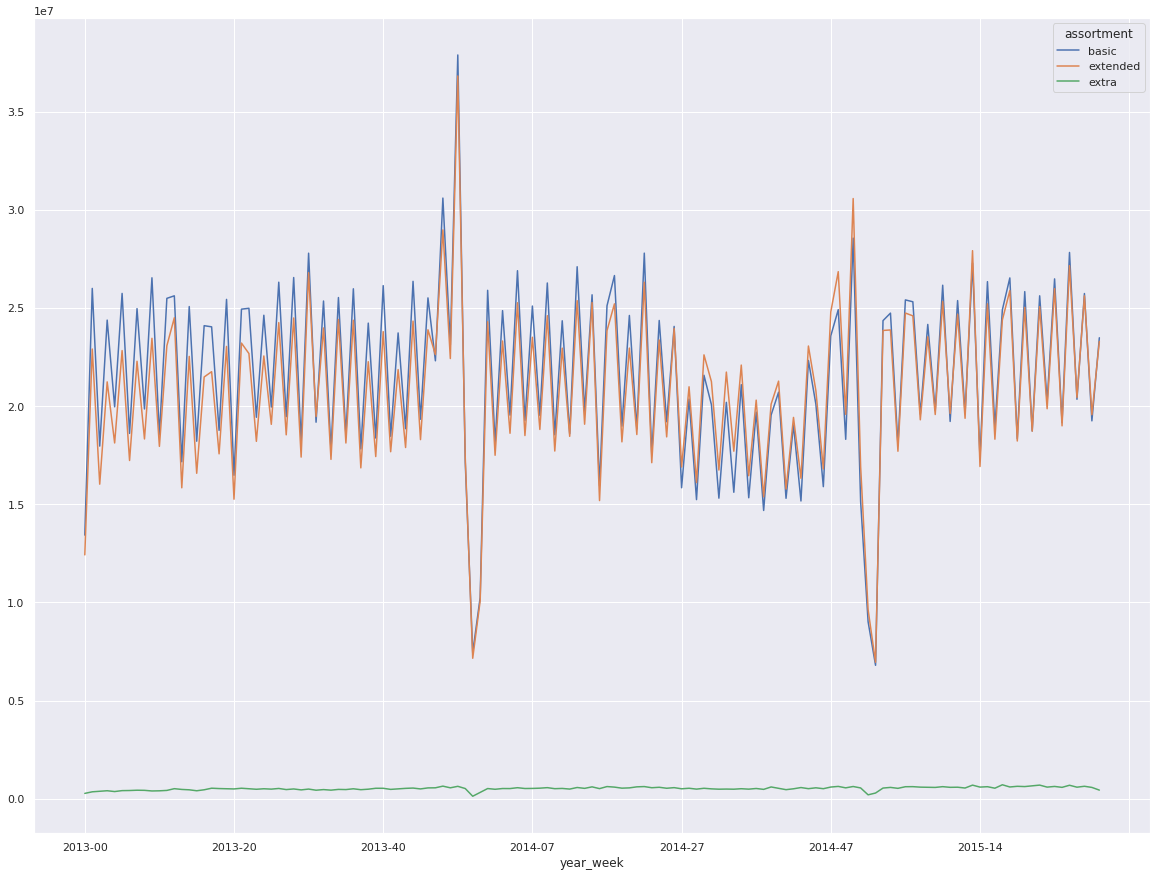

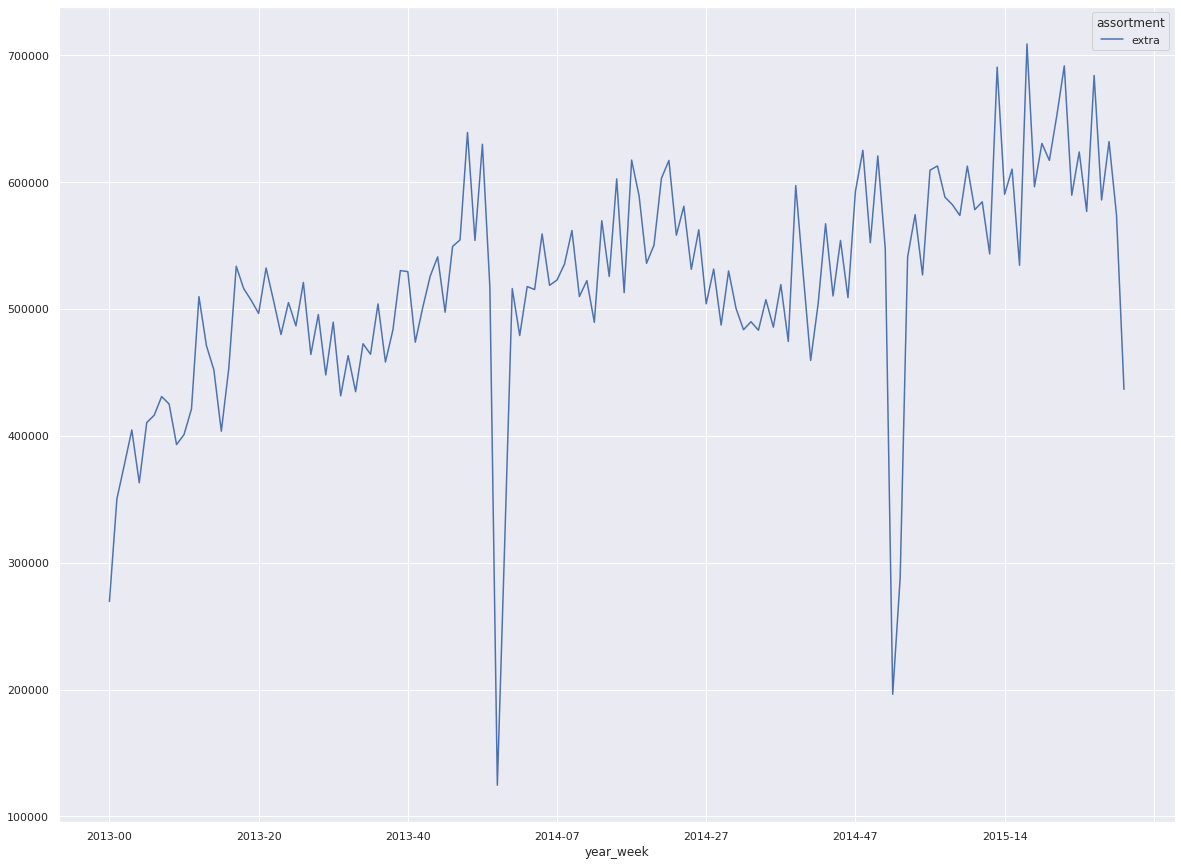

In [34]:
# Graph 1 - Total Sales by assortment
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 )
# Ao observar o gráfico podemos notar que a hipótese não é válida, por que a categoria extra que seria a com maior assortment na verdade vende muito menos que a basic e a extended. Dessa forma nos questionamo, será se a categoria extra vendia muito mais no passado e de tempos para cá por algum motivo passou a vender muito menos e por isso está tão baixo? Então iremos validar novamente essa hipótese.

# Graph 2 - assortment Sales by Week
aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

# Graph 3 - Total Extra assortment Sales
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()
# De fato a hipótese é falsa, durante todo o período as lojas com assortment extra tiveram um volume de venda extremamente baixo comparado com as outras. Em relação a importância dessa variável no modelo, provavelmente é importante mesmo o comportamento das categorias basic e extended serem extremamente parecidos, pois o comportamente sazonal da extra é diferente, enquanto que basic e extended fazem um pico altíssimo nas semanas finais do ano e depois uma grande queda, a categoria extra mostra apenas um aumento nas vendas seguida de uma quedra brusca.

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com competidores mais próximos vendem mais.

Apesar da baixíssima correlação dessa variável com a varável resposta, decidi deixar ela no modelo para um double check quando o for aplicar um algoritmo para indicar as variáveis mais impactantes já que correlação não é uma relação de causa e efeito e uma variável com baixa correlação ainda que raramente, pode ter um bom impacto no modelo.

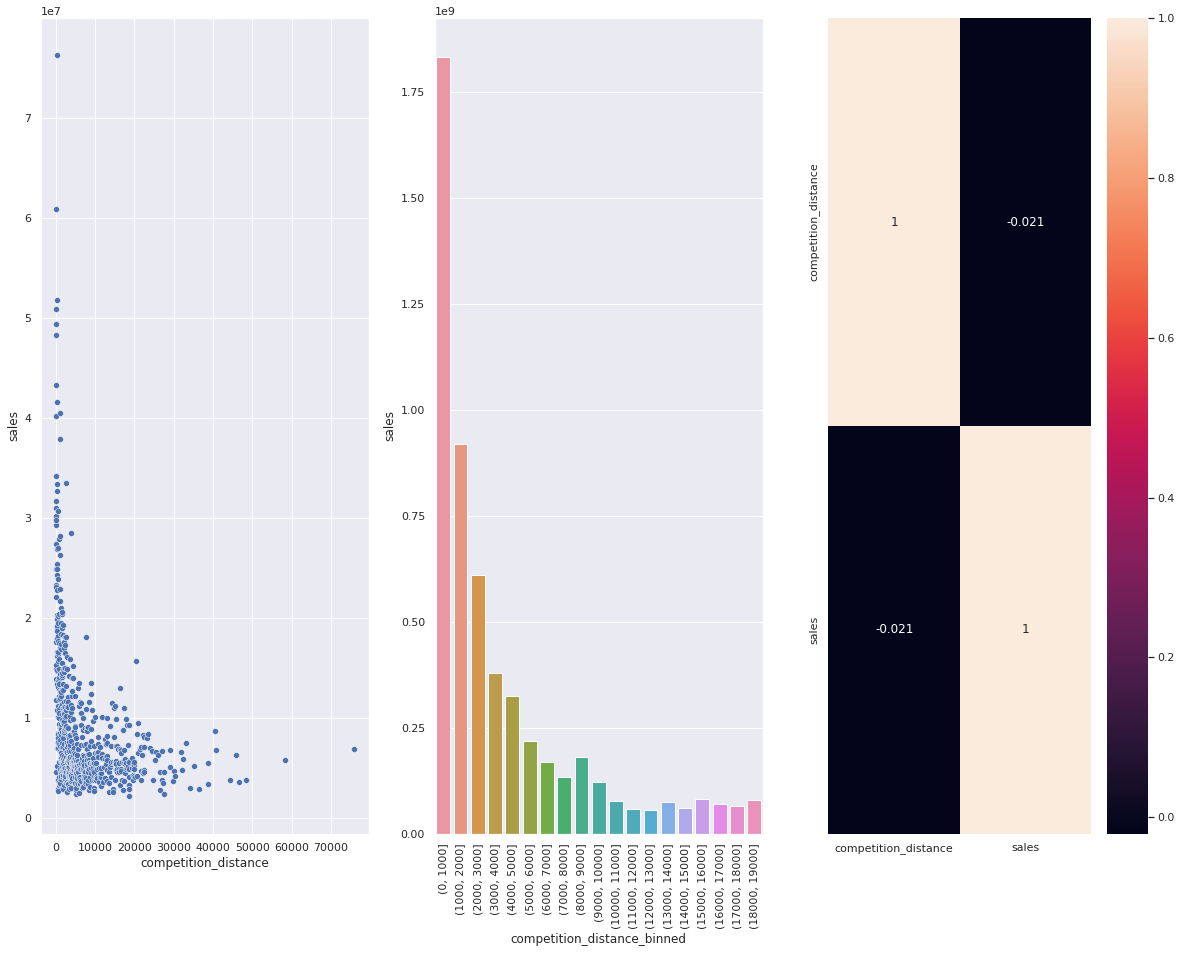

In [35]:
# Graph 1
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
aux2 = aux1[aux1['competition_distance'] < 100000]
sns.scatterplot( x='competition_distance', y='sales', data=aux2 );

# Graph 2
plt.subplot( 1, 3, 2 )
bins = list( arange( 0, 20000, 1000 ) )

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()

sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

# Graph 3
plt.subplot( 1, 3, 3 )
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H3.** Lojas com competidores a mais tempo deveriam vender mais.
**FALSA** Lojas com competidores a mais tempo vendem menos.

Apesar de ter uma correlação baixa de 0,1 a variável será mantida para o modelo ainda que tenha pouco impacto já que não é extremamente baixo como 0,0x. É possível notar também que nos momentos antes do competidor próximo abrir, as vendas cresceram até o dia em que ele abriu quando se tem um grande pico.

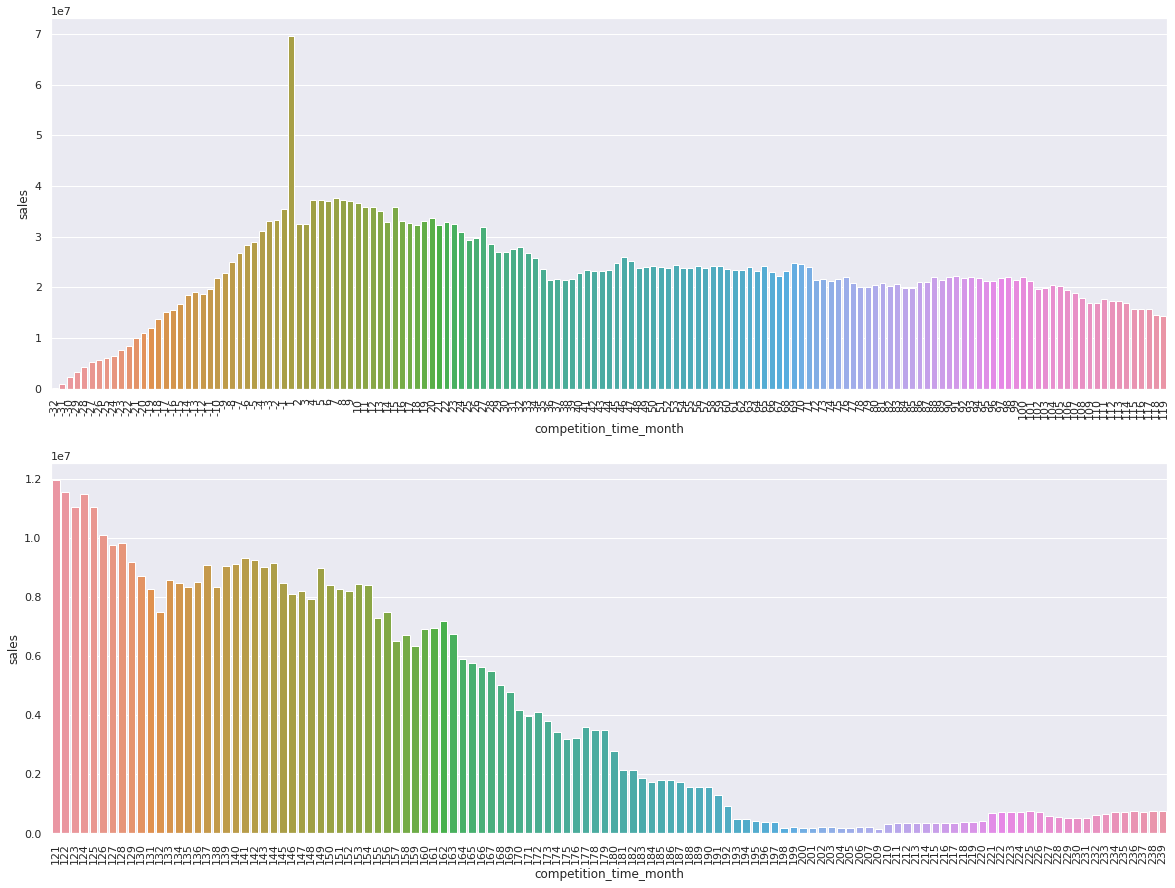

In [36]:
# Create Auxiliary Df's
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]

# Graph 1 - Competitors 1 - 120 months
plt.subplot( 2, 1, 1 )
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

# Graph 2 - Competitors 121 - 240 months
plt.subplot( 2, 1, 2 )
aux2 = aux1[( aux1['competition_time_month'] > 120 ) & ( aux1['competition_time_month'] < 240 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

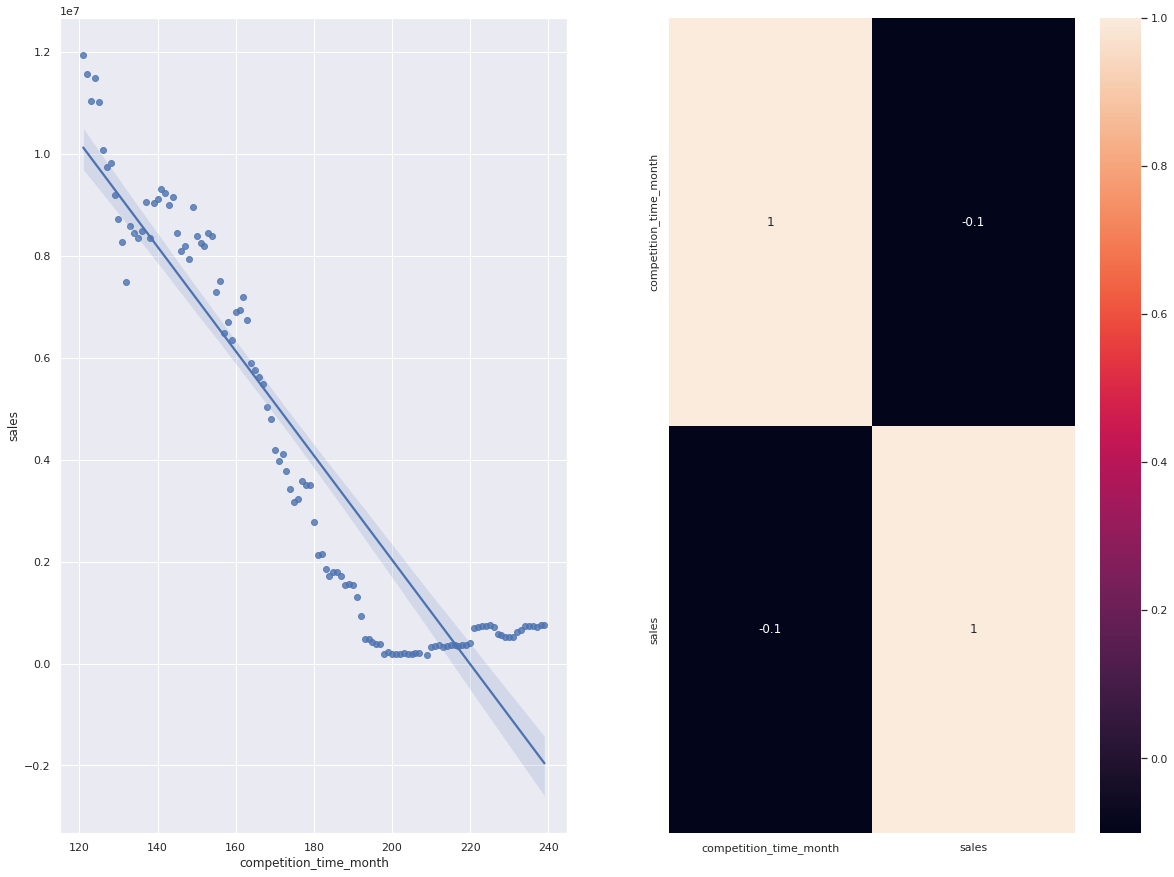

In [37]:
# Graph 3 - Competitors 121 - 240 months tendence
plt.subplot( 1, 2, 1 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

# Graph 4 - Competitors Correlation
plt.subplot( 1, 2, 2 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSA** Lojas com promoções ativas por mais tempo passam a vender menos depois de um certo tempo de promoção extendida.

Podemos ver que no gráfico da promoção regular as vendas são bem baixas no começo provavelmente o período sem nenhuma promoção e depois tem um pico que provavelmente é quando se iniciar a promoção regular e as vendas continuam subindo com algumas correções até uma correção mais forte indicando um começo de queda que é quando se inicia o período da promoção extendida.

No gráfico da promoção extendida nós conseguimos ver que ela consegue manter o nível de vendas em um patamar por muitas semanas até que chega um momento onde não é mais eficaz e começa a cair o nível de vendas.

A correlação dessa variável com a variável resposta é bem baixa, por conta do nível de vendas se manter estável em um mesmo nível durante a grande parte do tempo de promoção extendida, e por conta disso é bem possível que ela influencie pouco no modelo por ter pouco comportamento para ser aprendido.

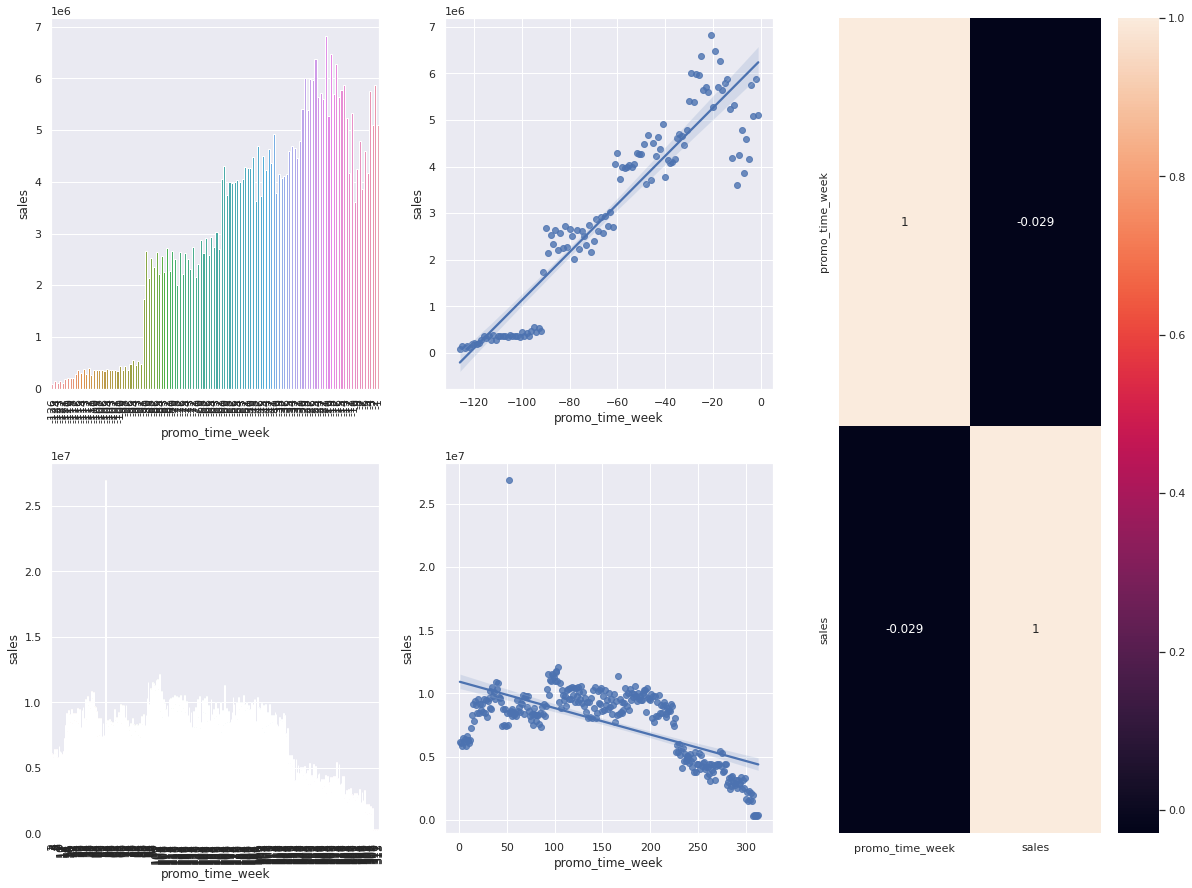

In [38]:
# Create Auxiliary Df
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

grid = GridSpec( 2, 3 )

# Graph 1 - Regular Promo
plt.subplot( grid[0, 0] )
aux2 = aux1[aux1['promo_time_week'] < 0]
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

# Graph 2 - Regular Promo Tendence
plt.subplot( grid[0, 1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

# Graph 3 - Extended Promo
plt.subplot( grid[1, 0] )
aux3 = aux1[aux1['promo_time_week'] > 0]
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

# Graph 4 - Extended Promo Tendence
plt.subplot( grid[1, 1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

# Graph 5 - Promo Time Week Correlation
plt.subplot( grid[:, 2] )
sns.heatmap( aux1.corr( 'pearson' ), annot=True );

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com promoções consecutivas vendem menos.

Apesar de lojas com promoções consecutivas venderem menos, o comportamente das vendas de lojas com e sem promoções extendidas são extremamente parecidos (exceto por um pequeno período de descolamento das linhas) o que provavelmente indica uma variável que pouco irá influenciar no modelo.

In [39]:
# Total Sales by Promo Combination
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


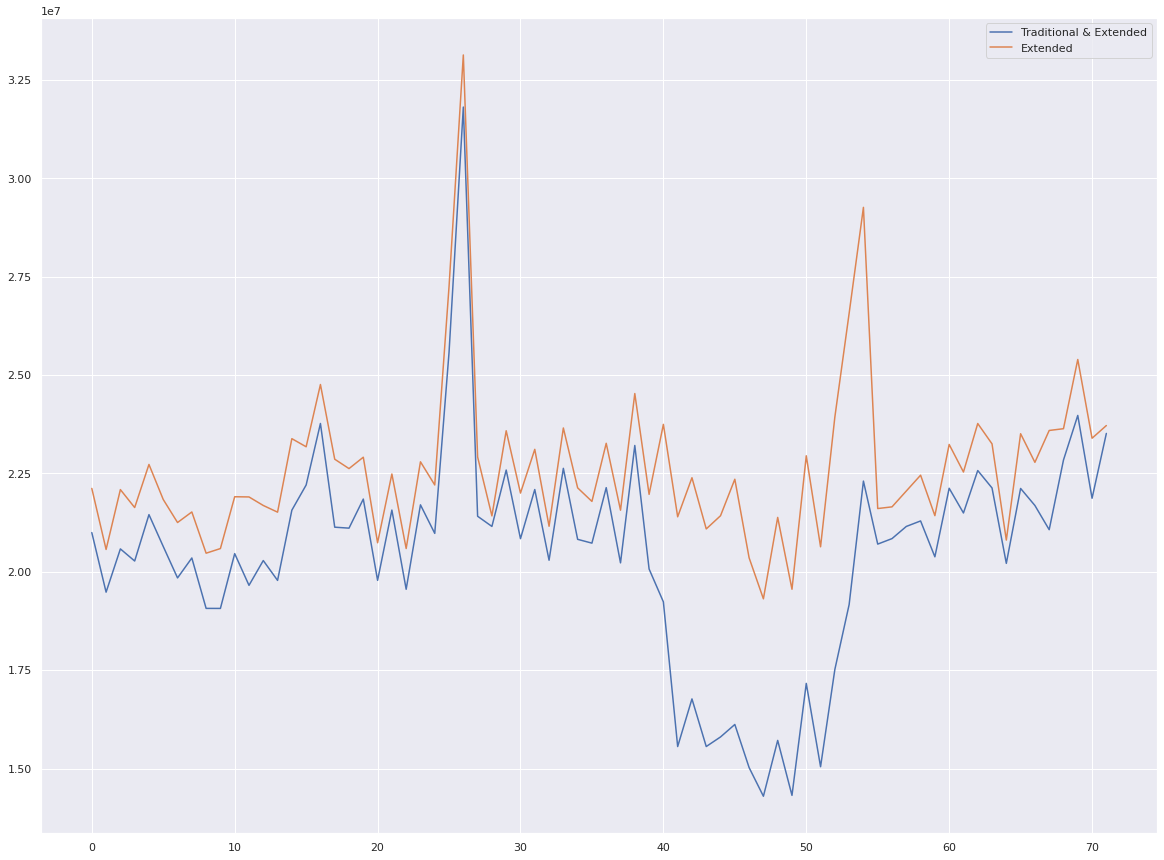

In [40]:
# Graph 1 - Traditional & Extended Sales vs Extended Sales
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax );

ax.legend( labels=['Traditional & Extended', 'Extended'] );

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado do natal vendem menos.


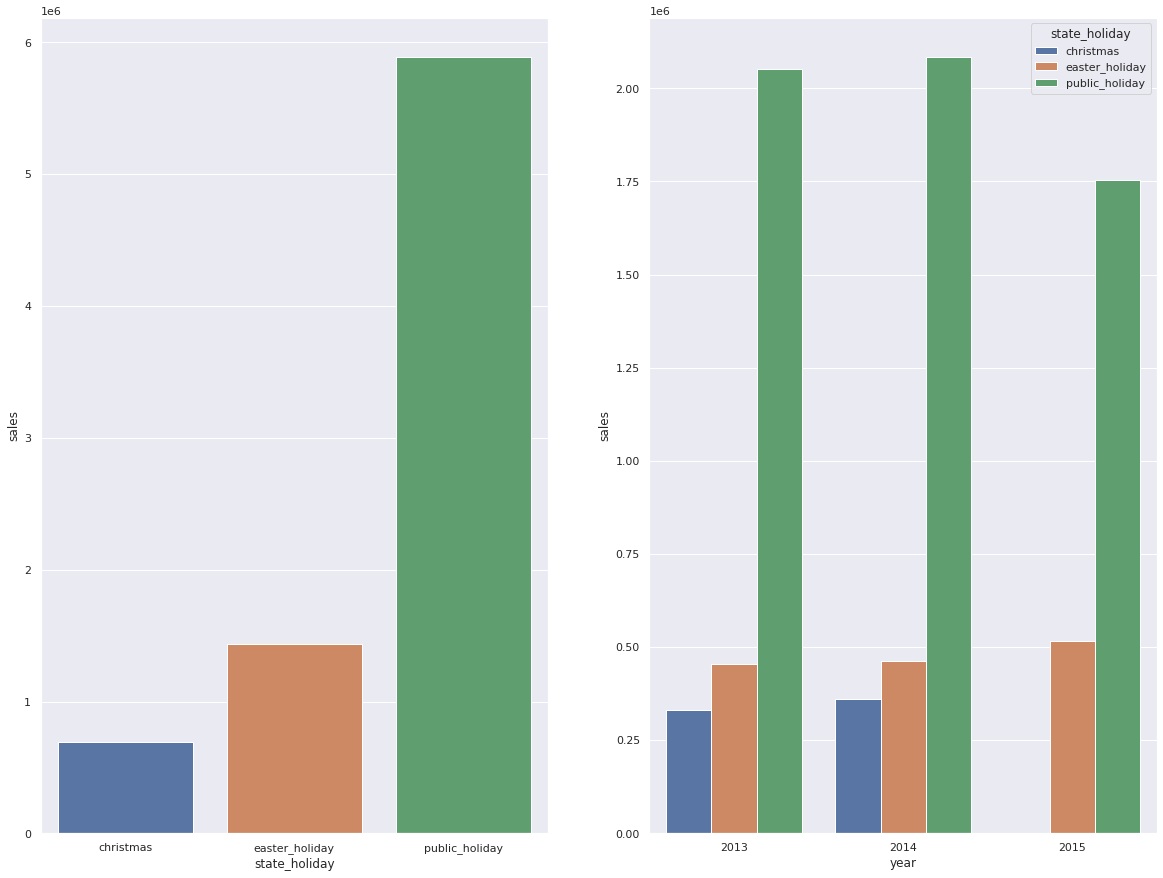

In [41]:
# Create Auxiliary Df
aux = df4[df4['state_holiday'] != 'regular_day']

# Graph 1 - Total Sales
plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

# Graph 2 - Sales by Year
plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos.

Apesar da análise estar enviesada por conta do ano de 2015 não estar fechado e isso gerar uma correlação mais alta do que de fato é já que ainda terõ mais vendas em 2015, analisando apenas os de 2013 e 2014 já podemos perceber a diminuição do nível de vendas e ainda que essa correlação abaixe se desconsiderar o ano de 2015 ainda será uma correlação alta tornando uma variável provavelmente importante para o modelo. Apesar de não ser um insight, é um problema gravíssimo a longo prazo a diminuição das vendas ano após ano.

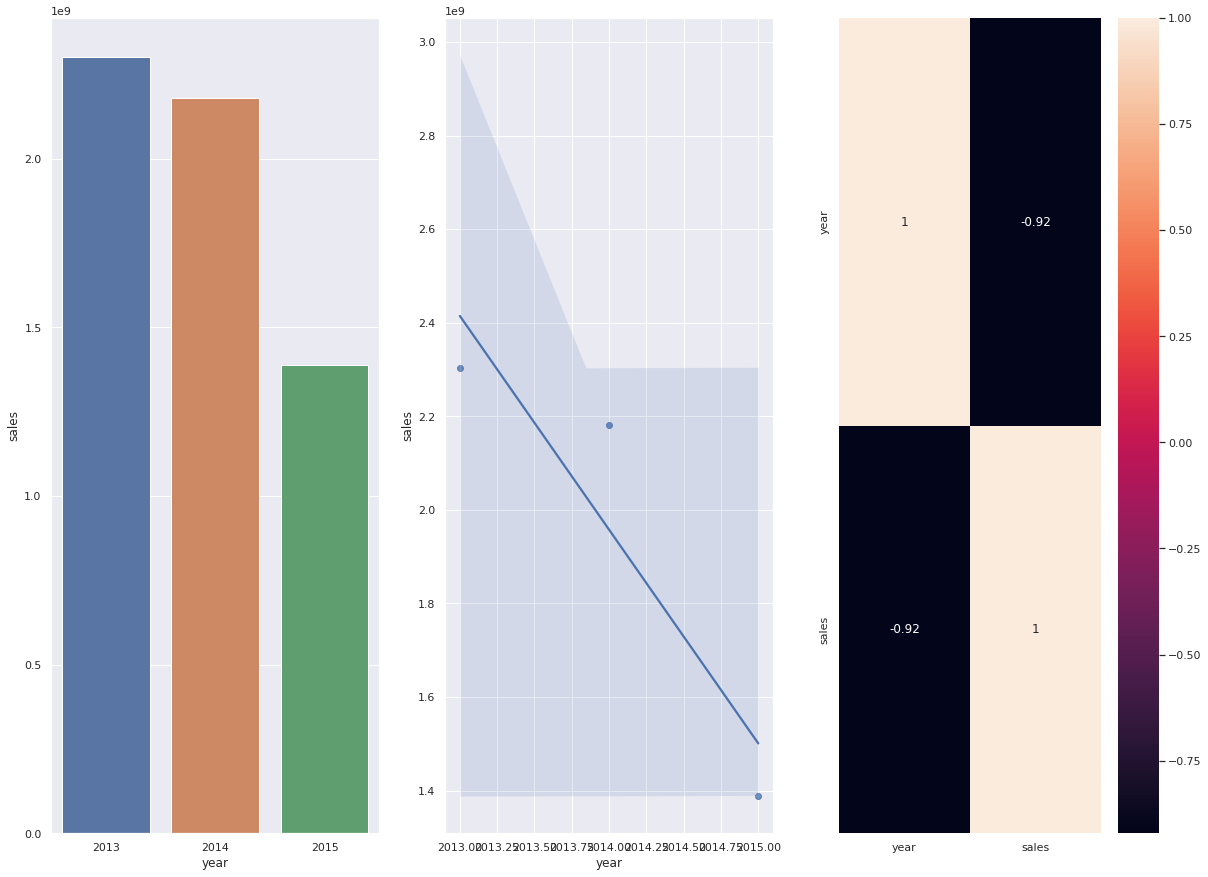

In [42]:
# Create Auxiliary Df
aux = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

# Graph 1 - Sales by Year
plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux );

# Graph 2 - Sales by Year Tendence
plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux );

# Graph 3 - Sales by Year Correlation
plt.subplot( 1, 3, 3 )
sns.heatmap( aux.corr( method='pearson' ), annot=True );

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano.

Mais uma variável com forte correlação e muito informação para ser aprendida pelo modelo, e não necessariamente é um prolema já que muitos produtos possuem comportamentos sazonais de venda ao longo do ano.

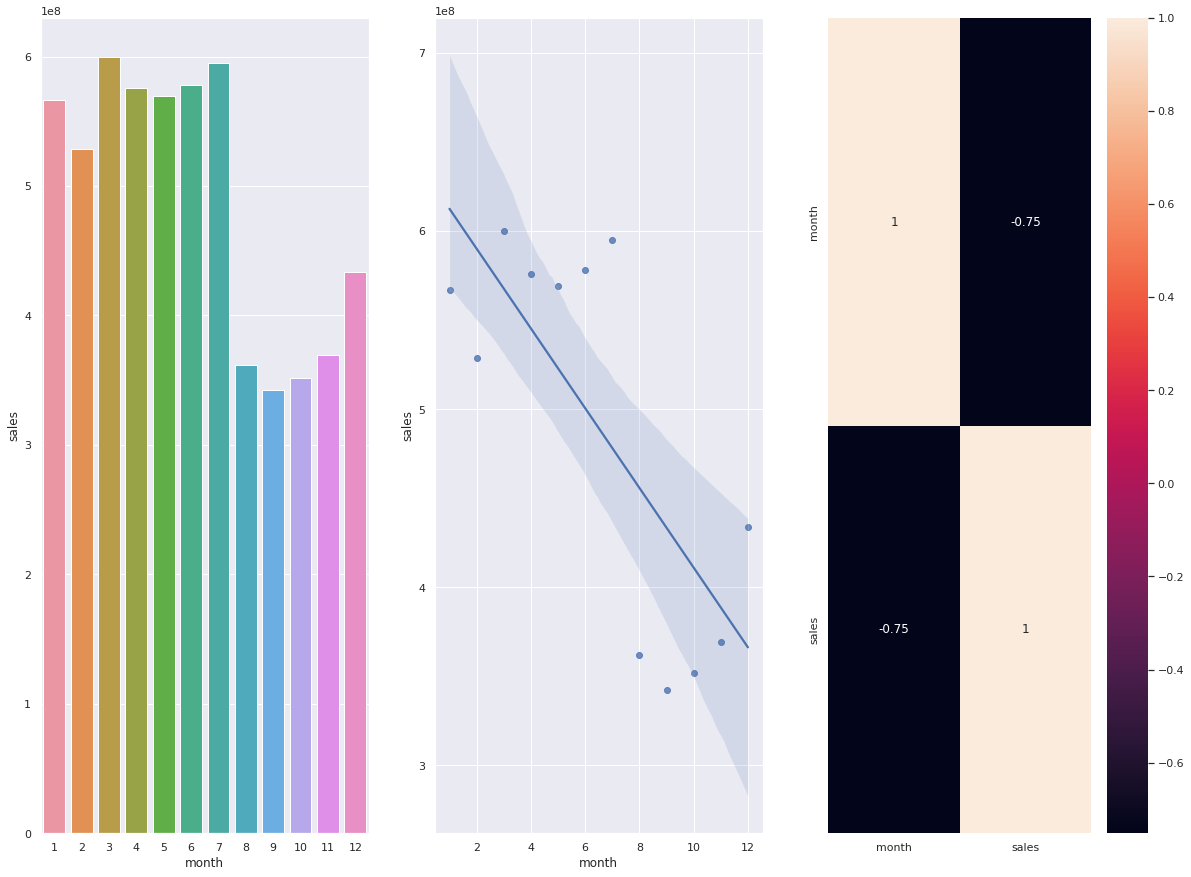

In [43]:
# Create Auxiliary Df
aux = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

# Graph 1 - Sales by Month
plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux );

# Graph 2 - Sales by Month Tendence
plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux );

# Graph 3 - Sales by Month Correlation
plt.subplot( 1, 3, 3 )
sns.heatmap( aux.corr( method='pearson' ), annot=True );

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** As lojas vendem mais depois do dia 10 de cada mês.

Apesar de ser esperado de que a hipótese fosse verdadeira pela grande diferença de tempo na comparação, a variável mostrou uma correlação média com a variável resposta, pondendo ter importância para o modelo.

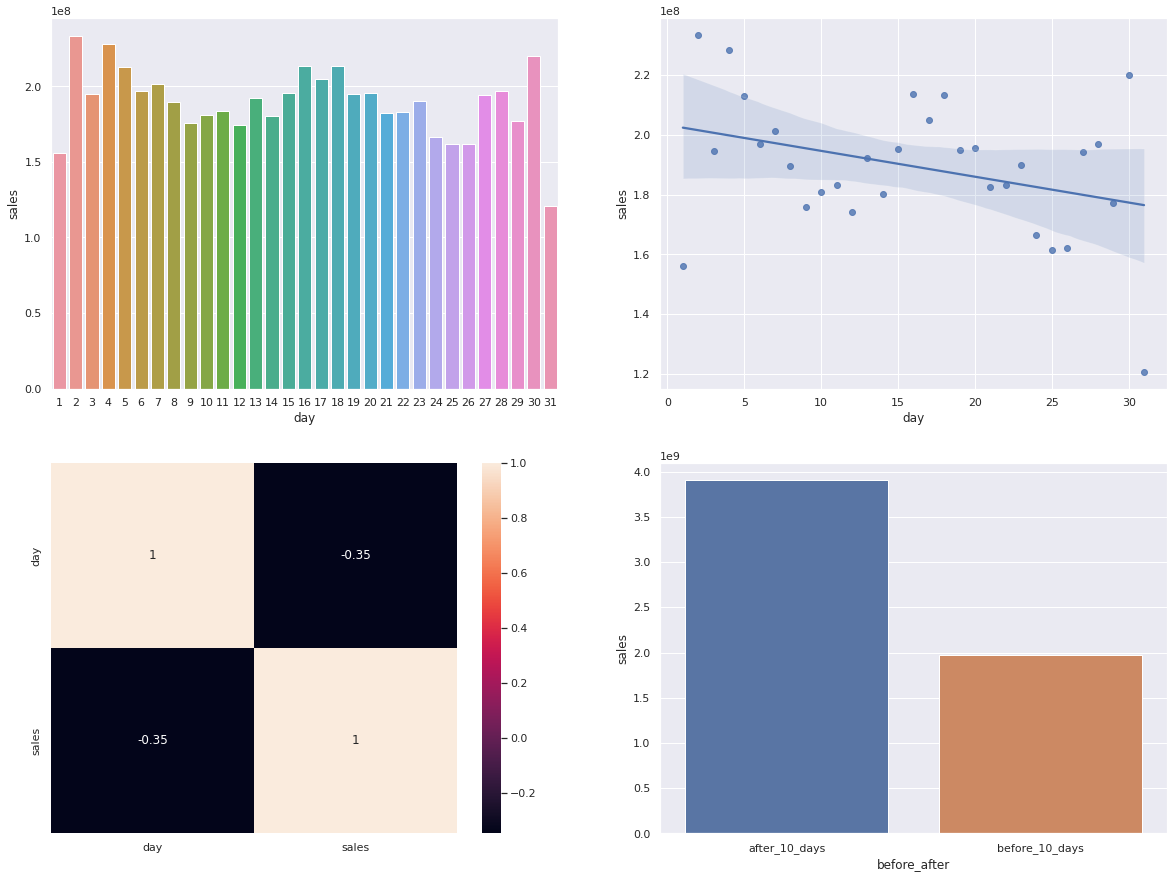

In [44]:
# Create Auxiliary Df
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

# Graph 1 - Sales by Month
plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

# Graph 2 - Sales by Month Tendence
plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

# Graph 3 - Sales by Month Correlation
plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

# Create Column
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

# Graph 4 - 
plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### **H11.** Lojas deveriam vender menos aos finais de cada semana.
**VERDADEIRA** As lojas vendem menos nos finais de semana, e principalmente domingo, com um volume bem baixo.

A alta correlação negativa já mostra que a medida que os dias da semana vão aumentando, a quantidade de vendas vai se diminuindo e que essa variável será importante para o modelo.

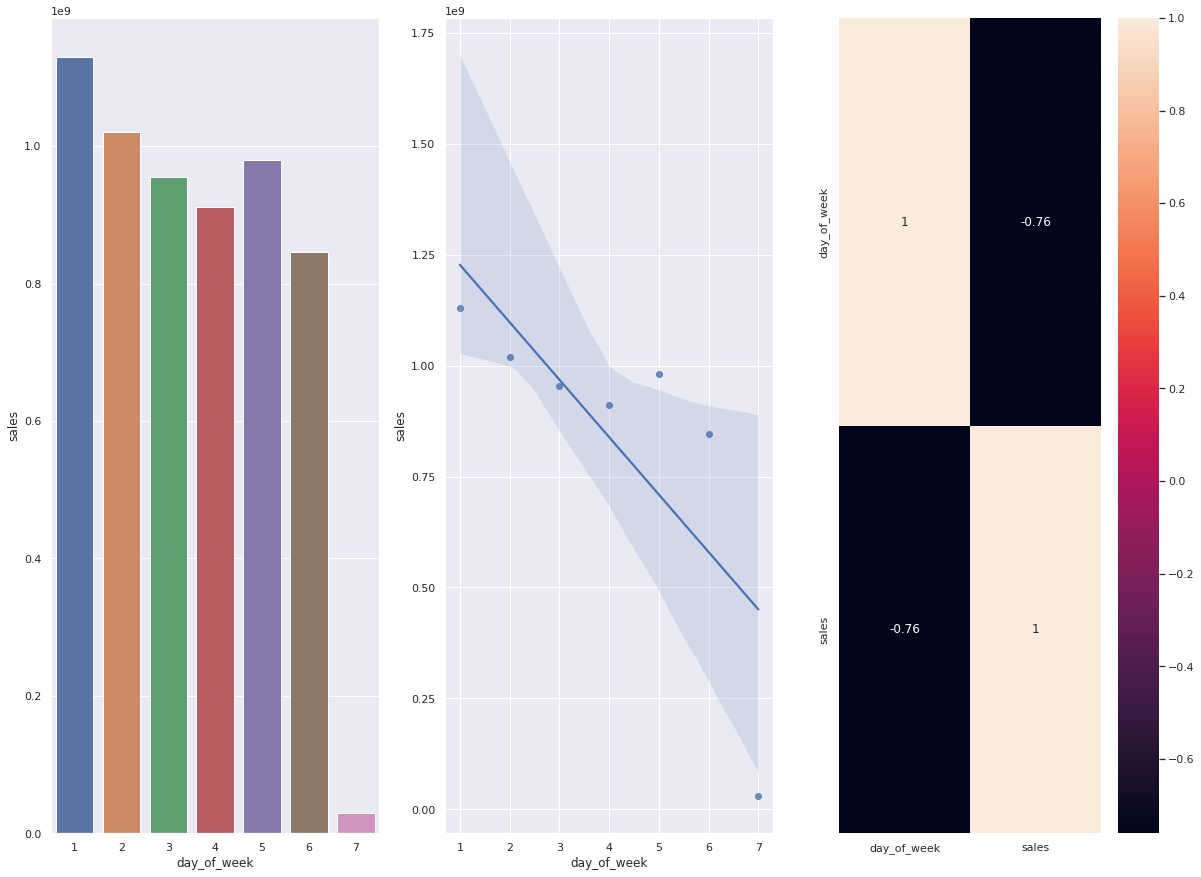

In [45]:
# Create Auxiliary Df
aux = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

# Graph 1 - Sales by Year
plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux );

# Graph 2 - Sales by Year Tendence
plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux );

# Graph 3 - Sales by Year Correlation
plt.subplot( 1, 3, 3 )
sns.heatmap( aux.corr( method='pearson' ), annot=True );

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** As lojas vendem menos durante os feriados escolares, com a excessão dos meses de julho onde as vendas são praticamente as mesmas, e agosto onde as vendas nos feriads são muito maiores. Provável efeito das férias escolares.

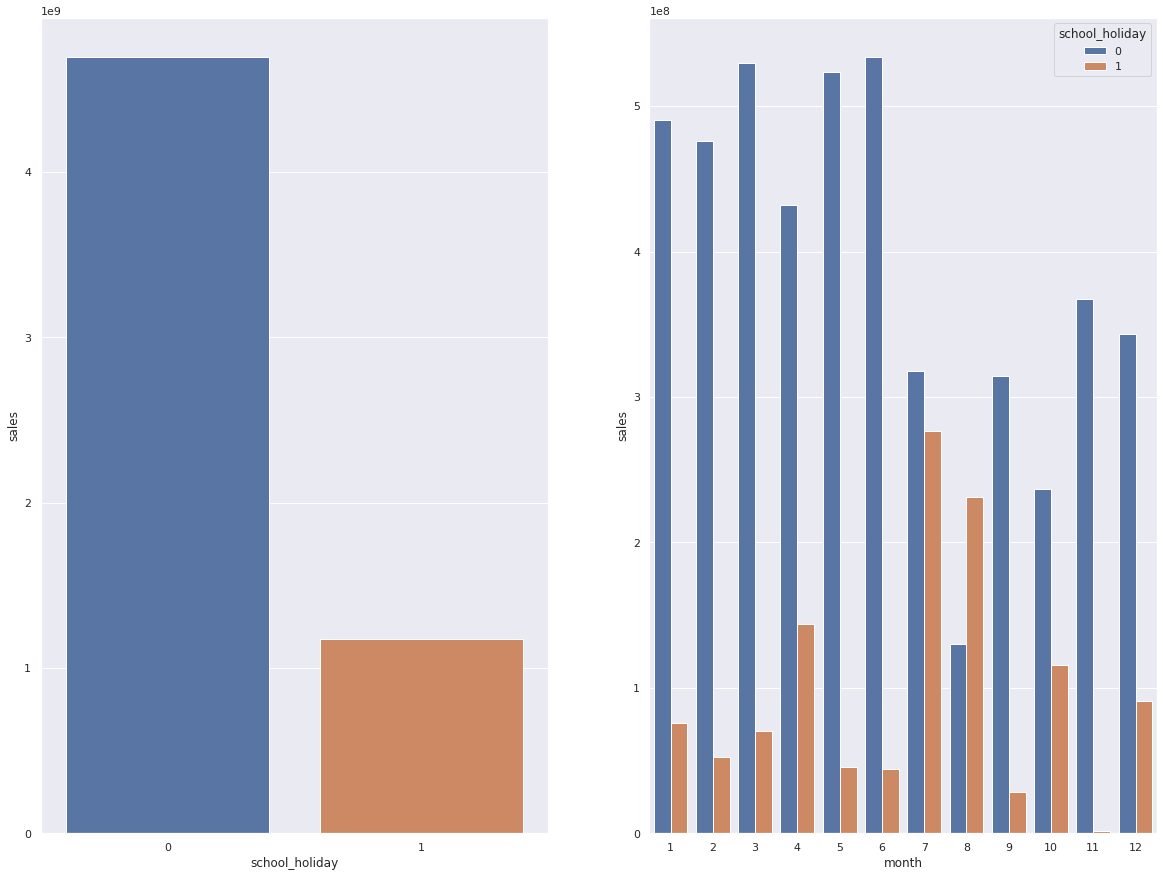

In [46]:
# Graph 1 - Total school_holiday Sales
plt.subplot( 1, 2, 1 )
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
sns.barplot( x='school_holiday', y='sales', data=aux1 );

# Graph 2 - school_holiday Sales by Month
plt.subplot( 1, 2, 2 )
aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['school_holiday', 'month'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 4.2.1 Hypotheses Summary

In [47]:
tab = [['Hypotheses', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'Low'],
       ['H3', 'False', 'Average'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'False', 'Average'],
       ['H8', 'False', 'High'],
       ['H9', 'False', 'High'],
       ['H10', 'True', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'Low']
]
print( tabulate( tab, headers='firstrow' ) )

Hypotheses    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Low
H3            False         Average
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Average
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

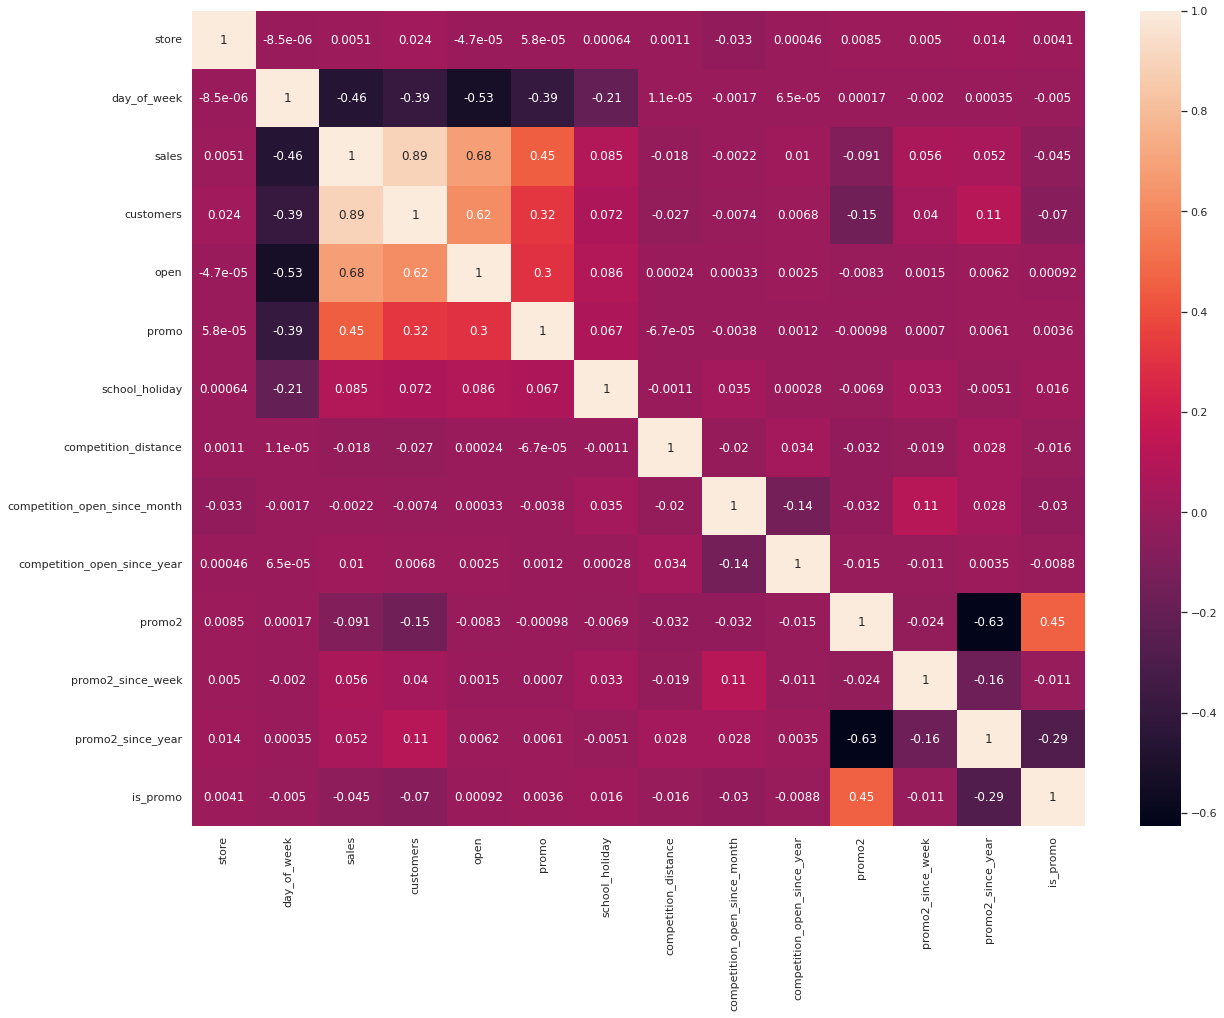

In [48]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2 Categorical Attributes

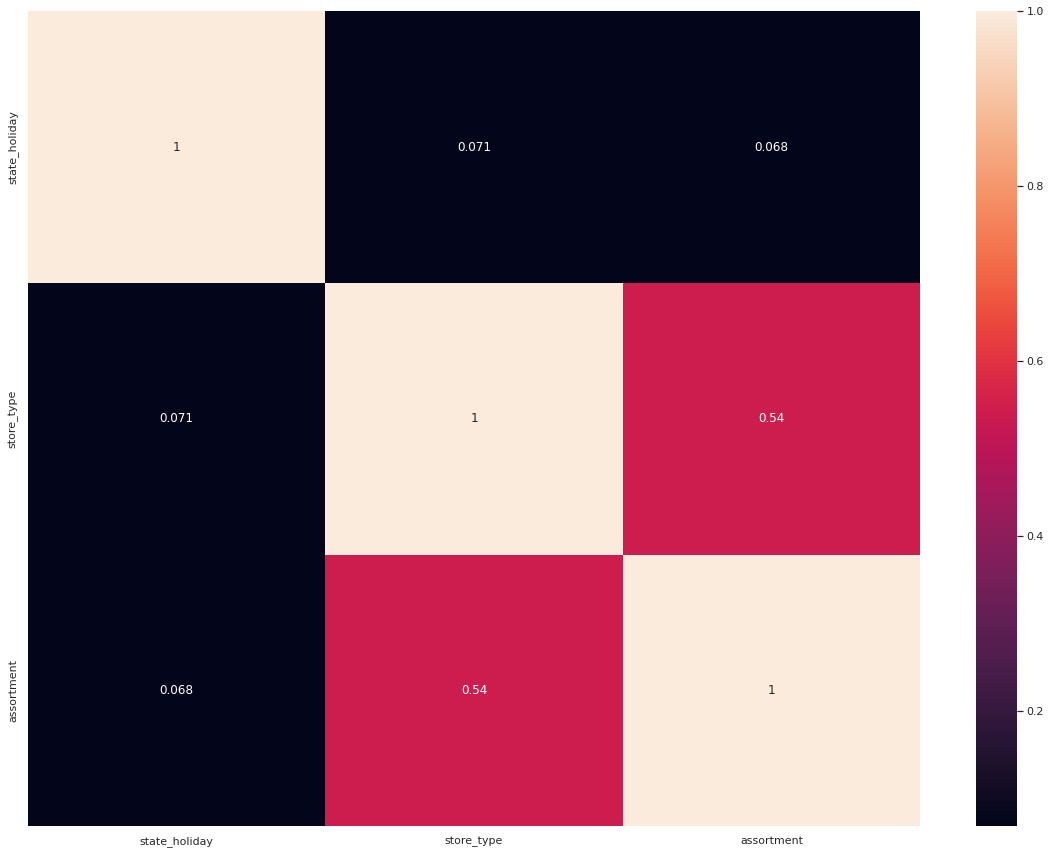

In [49]:
# Create Categorical DataFrame
a = df4.select_dtypes( include='object' )

# Calculate Cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final Dataset
b = pd.DataFrame( { 'state_holiday': [a1, a2, a3], 
                'store_type': [a4, a5, a6], 
                'assortment': [a7, a8, a9] } )

b = b.set_index( b.columns )

# Graph 1 - Heatmap
sns.heatmap( b, annot=True );

# 5.0 STEP 05 - DATA PREPARATION

In [50]:
df5 = df4.copy()

## 5.1 Normalization

In [51]:
# Nenhuma das distribuições das variáveis estão se quer próximas de uma ditribuições normal, por conta disso não será aplicada nenhuma normalização.

## 5.2 Rescaling

In [52]:
# Rename Scaler's
rs = RobustScaler()
mms = MinMaxScaler()

# Competition Distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( '/home/jeffsmedines/repos/ds_producao/parameter/competition_distance_scaler.pkl', 'wb' ) )

# Competition Time Month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( '/home/jeffsmedines/repos/ds_producao/parameter/competition_time_month_scaler.pkl', 'wb' ) )


# Promo Time Week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( mms, open( '/home/jeffsmedines/repos/ds_producao/parameter/promo_time_week_scaler.pkl', 'wb' ) )

# Year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( '/home/jeffsmedines/repos/ds_producao/parameter/year_scaler.pkl', 'wb' ) )

## 5.3 Transformation

### 5.3.1 Encoding

In [53]:
# state_holiday - Essa variável por expressar um estado, foi utilizado One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Será utilizado o Label Encoding já que não fica explícito em nenhum lugar qual a lógico dos valores de store (a, b, c)
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( '/home/jeffsmedines/repos/ds_producao/parameter/store_type_scaler.pkl', 'wb' ) )

# assortment - Será utilizado um Ordinal Encoding por conta da ordem de grandeza do assortment.
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 Response Variable Transformation

In [54]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3 Nature Transformation

In [55]:
# Day of Week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# Month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )


# Day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )


# Week of Year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0 STEP 06 - FEATURE SELECTION

In [56]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [57]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [58]:
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=7*6 )

Timestamp('2015-06-19 00:00:00')

In [59]:
# Training Dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Test Dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

a = X_train['date'].min()
b = X_train['date'].max()
c = X_test['date'].min()
d = X_test['date'].max()

print( f'Training Min Date: {a}' )
print( f'Training Max Date: {b}' )
print( '===========================' )
print( f'Test Min Date: {c}' )
print( f'Test Max Date: {d}' )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00
Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [60]:
# # Training and Test dataset for Boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# # Define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

# # Define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1 Best Features from Boruta

In [61]:
# cols_selected = boruta.support_.tolist()

# # Best Features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # Not Selected Boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3 Manual Feature Selection

In [62]:
# Além das variáveis indicadas pelo boruta como importante, nesse primeiro ciclo do CRISP irei edicionar também as variáveis de sen e cos onde o boruta tenha deixado alguma de fora já que é necessário as duas colunas para representar uma informação, então deixar apenas uma não teria sentido.
cols_selected_boruta = [
    'store', 
    'promo', 
    'store_type', 
    'assortment', 
    'competition_distance', 
    'competition_open_since_month', 
    'competition_open_since_year', 
    'promo2', 
    'promo2_since_week', 
    'promo2_since_year', 
    'competition_time_month', 
    'promo_time_week', 
    'day_of_week_sin', 
    'day_of_week_cos', 
    'month_sin', 
    'month_cos', 
    'day_sin', 
    'day_cos', 
    'week_of_year_sin', 
    'week_of_year_cos']

# Columns to Add
feat_to_add = ['date', 'sales']

# Final Features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 STEP 07 - MACHINE LEARNING MODELLING

In [63]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 Average Model

In [64]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression Model

In [65]:
# Model
lr = LinearRegression().fit( x_train, y_train )

# Prediction
yhat_lr = lr.predict( x_test )

# Performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1863.628669,0.292165,2673.142689


### 7.2.1 Linear Regression Model - Cross Validation

In [66]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2083.17 +/- 294.98,0.3 +/- 0.02,2958.87 +/- 466.72


## 7.3 Linear Regression Regularized Model - Lasso

In [67]:
# Model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# Prediction
yhat_lrr = lrr.predict( x_test )

# Performance
lrr_result = ml_error( 'Linear Regression Regularized - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized - Lasso,1889.982643,0.288951,2745.968967


In [68]:
# Ao aplicar o modelo baseline de média e comparar com os modelos lineares, o erro RMSE dos modelos lineares são bem maiores que o de média, mostrando que esse problema não é simples e linear sendo necessário modelos mais robustos para ter uma boa performance.

### 7.3.1 Linear Regression Regularized Model - Lasso - Cross Validation

In [69]:
lrr_result_cv = cross_validation( x_training, 5, 'Linear Regression Regularized', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Regularized,2117.66 +/- 340.94,0.29 +/- 0.01,3061.89 +/- 503.23


## 7.4 Random Forest Regressor

In [70]:
# Model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# Prediction
yhat_rf = rf.predict( x_test )

# Performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738


### 7.4.1 Random Forest Regressor - Cross Validation

In [71]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest', rf, verbose=False )
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28


## 7.5 XGBoost Regressor

In [72]:
# Model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror', 
                              n_estimators=100, 
                              eta=0.3, 
                              max_depth=10, 
                              subsample=0.7, 
                              colsample_bytree=0.9 ).fit( x_train, y_train )

# Prediction
yhat_xgb = model_xgb.predict( x_test )

# Performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,706.124474,0.101986,1033.600153


### 7.5.1 XGBoost Regressor - Cross Validation

In [73]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False )
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,913.11 +/- 161.5,0.13 +/- 0.02,1306.38 +/- 236.62


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [74]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738
0,XGBoost Regressor,706.124474,0.101986,1033.600153
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1863.628669,0.292165,2673.142689
0,Linear Regression Regularized - Lasso,1889.982643,0.288951,2745.968967


### 7.6.1 Real Performance - Cross Validation

In [75]:
modelling_result_cv = pd.concat( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv ] )
modelling_result_cv.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28
0,XGBoost Regressor,913.11 +/- 161.5,0.13 +/- 0.02,1306.38 +/- 236.62
0,Linear Regression,2083.17 +/- 294.98,0.3 +/- 0.02,2958.87 +/- 466.72
0,Linear Regression Regularized,2117.66 +/- 340.94,0.29 +/- 0.01,3061.89 +/- 503.23


In [76]:
# Apesar da Random Forest apresentar um desempenho um pouco melhor do que o modelo XGBoost, será escolhido seguir com o XGBoost por conta da Random Forest necessitar de muito mais memória de nuvem para colocar em produção tendo um custo bem maior,  a pequena perda de desempenho será muito compensada pelo menor custo de produção, além de o modelo XGBoost ter mostrado um desvio padrão bem menor, logo, está exposto e menores variações.

# 8.0 STEP 08 - HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [77]:
param = { 'n_estimators': [1500, 1700, 2500, 3000, 3500], 
          'eta': [0.3], 
          'max_depth': [3, 5, 9], 
          'subsample': [0.1, 0.5, 0.7], 
          'colsample_bytree': [0.3, 0.7, 0.9], 
          'min_child_weight': [3, 8, 15] }

MAX_EVAL = 10

In [78]:
# final_result = pd.DataFrame()
# for i in range( MAX_EVAL ):
#     # Choose values for parameters randomly
#     hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#     print( hp )
    
#     # Model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror', 
#                                   n_estimators=hp['n_estimators'], 
#                                   eta=hp['eta'], 
#                                   max_depth=hp['max_depth'], 
#                                   subsample=hp['subsample'], 
#                                   colsample_bytree=hp['colsample_bytree'],
#                                   min_child_weight=hp['min_child_weight'])



#     # Performance
#     result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False )
#     final_result = pd.concat( [final_result, result] )
    
# final_result

## 8.2 Final Model

In [79]:
# Best parameters values by Random Search
# {'n_estimators': 1700, 'eta': 0.3, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}

In [80]:
param_tuned = { 'n_estimators': 1700, 
          'eta': 0.3, 
          'max_depth': 9, 
          'subsample': 0.7, 
          'colsample_bytree': 0.9, 
          'min_child_weight':  15 }

In [81]:
# # Model
# model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror', 
#                                     n_estimators=param_tuned['n_estimators'], 
#                                     eta=param_tuned['eta'], 
#                                     max_depth=param_tuned['max_depth'], 
#                                     subsample=param_tuned['subsample'], 
#                                     colsample_bytree=param_tuned['colsample_bytree'],
#                                     min_child_weight=param_tuned['min_child_weight']).fit( x_train, y_train )

# # Prediction
# yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# # Performance
# xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
# xgb_result_tuned

In [82]:
# Save the model to disk
# pickle.dump( model_xgb_tuned, open( '/home/jeffsmedines/repos/ds_producao/model/model_rossmann.pkl', 'wb' ) )

# Load the model from disk
model_xgb_tuned = pickle.load( open( '/home/jeffsmedines/repos/ds_producao/model/model_rossmann.pkl', 'rb' ) )

# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# Performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,710.82246,0.103115,1018.853033


In [83]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

0.00800665131722498

# 9.0 STEP 09 - ERROR TRANSLATION AND INTERPRETATION

In [84]:
df9 = X_test[ cols_selected_boruta_full ]

# Rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1 Business Performance

In [85]:
# Sum of Predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0: 'MAE'} )
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0: 'MAPE'} )

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Ordem Columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE' ]]

In [86]:
df92.sort_values( 'MAPE', ascending=False ).head( 10 )

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,105597.617188,102300.053043,108895.181332,3297.564145,0.550666
908,909,234382.890625,226688.750764,242077.030486,7694.139861,0.519254
875,876,190734.375000,186527.820132,194940.929868,4206.554868,0.316381
182,183,210616.859375,209000.065067,212233.653683,1616.794308,0.276576
273,274,190166.062500,188649.110970,191683.014030,1516.951530,0.260754
1038,1039,352841.843750,350882.094185,354801.593315,1959.749565,0.258197
285,286,159969.484375,159260.943613,160678.025137,708.540762,0.217607
930,931,159882.187500,158915.454675,160848.920325,966.732825,0.206191
533,534,297989.312500,296702.566961,299276.058039,1286.745539,0.205161
549,550,222975.890625,221989.055123,223962.726127,986.835502,0.202784


<AxesSubplot:xlabel='store', ylabel='MAPE'>

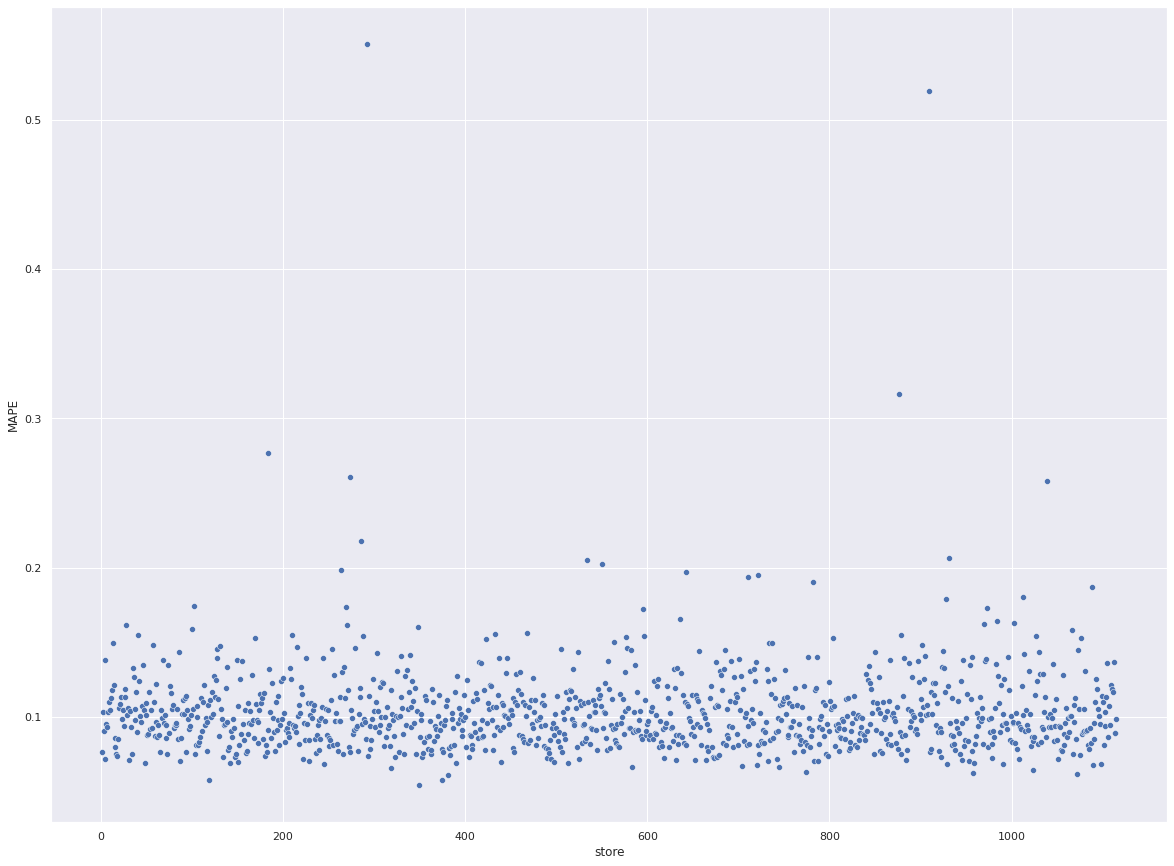

In [87]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2 Total Performance

In [88]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenarios', 0: 'Values'} )
df93['Values'] = df93['Values'].map( 'R$ {:,.2f}'.format )
df93

,Scenarios,Values
0,predictions,"R$ 283,744,256.00"
1,worst_scenario,"R$ 282,948,122.76"
2,best_scenario,"R$ 284,540,394.96"


## 9.3 Machine Learning Performance

In [89]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

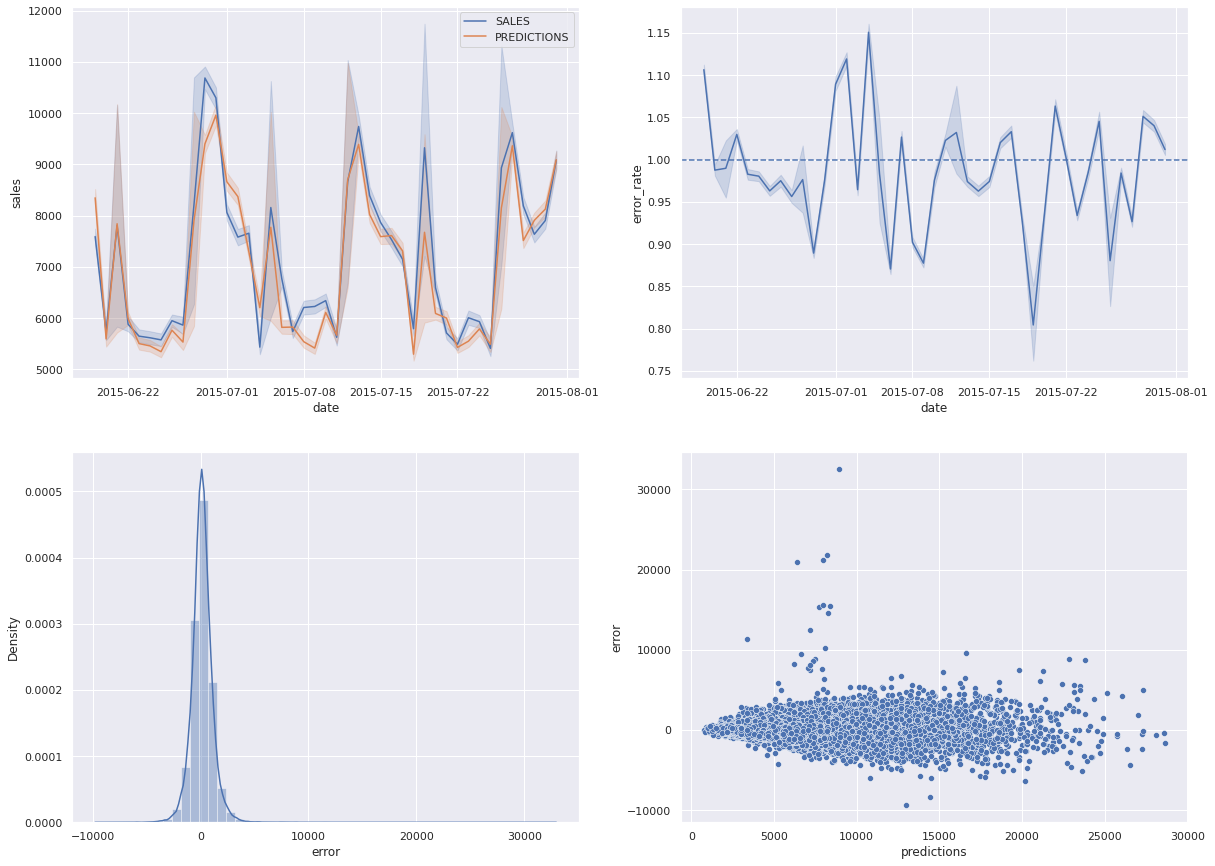

In [90]:
# Graph 1 - Sales and Predictions by date
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

# Graph 2 - Error Rate by date
plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--' )

# Graph 3 - Error Distribution
plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

# Graph 4 - Predictions by date
plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

# 10.0 STEP 10 - DEPLOY MODEL TO PRODUCTION

In [91]:
# pickle.dump( model_xgb_tuned, open( '/home/jeffsmedines/repos/ds_producao/model/model_rossmann.pkl', 'wb' ) )

## 10.1 Rossmann Class

In [138]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path = '/home/jeffsmedines/repos/ds_producao/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb' ) )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb' ) )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb' ) )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb' ) )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb' ) )
        
        state = 1
        
    def data_cleaning( self, df1 ):
        ## 1.1 Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                    'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
                    'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # Cols Rename
        df1.columns = cols_new

        ## 1.3 Data Types

        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5 Fillout NA's

        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 2000000.0 if math.isnan( x ) else x )

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(
            x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(
            x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else
                                             x['promo2_since_week'], axis=1 )

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else
                                             x['promo2_since_year'], axis=1 )

        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct',
                     11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna( 0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if
                                                                     x['month_map'] in x['promo_interval'].split( ',' ) else 0,
                                                                     axis=1 )

        ## 1.6 Change Types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        df1['competition_distance'] = df1['competition_distance'].astype( int )
        
        return df1
    
    def feature_engineering( self, df2 ):
        ## 2.4 Feature Engineering
        # Year
        df2['year'] = df2['date'].dt.year

        # Month
        df2['month'] = df2['date'].dt.month

        # Day
        df2['day'] = df2['date'].dt.day

        # Week of Year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # Year Week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # Competitive since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'],
                                                                    month=x['competition_open_since_month'] , day=1 ), axis=1 )

        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype(
            int )

        # Promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) -
                                                       datetime.timedelta( days=7 ) )

        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )

        # Assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # State Holiday a = public holiday, b = Easter holiday, c = Christmas
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 
                                                          'b' else 'christmas' if x == 'c' else 'regular_day' )

        ## 3.1 Row Filtering
        df2 = df2[df2['open'] != 0]

        ## 3.2 Columns Selection

        cols_drop = ['open', 'promo_interval', 'month_map']

        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2
    
    
    def data_preparation( self, df5 ):
        ## 5.2 Rescaling
        # Competition Distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values )

        # Competition Time Month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform( df5[['competition_time_month']].values )

        # Promo Time Week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform( df5[['promo_time_week']].values )
        
        # Year
        df5['year'] = self.year_scaler.transform( df5[['year']].values )

        ### 5.3.1 Encoding
        # state_holiday - Essa variável por expressar um estado, foi utilizado One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - label Encoding
        df5['store_type'] = self.store_type_scaler.transform( df5['store_type'] )

        # assortment - Será utilizado um Ordinal Encoding por conta da ordem de grandeza do assortment.
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        ### 5.3.3 Nature Transformation
        # Day of Week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # Month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )


        # Day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )


        # Week of Year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        # Feature Selection
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 
                                'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 
                                'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 
                                'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 
                                'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        # Predictions
        pred = model.predict( test_data )
        
        # Join pred into the original_data
        original_data['predictions'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2 API Handler

In [196]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# Loading Model
model = pickle.load( open( '/home/jeffsmedines/repos/ds_producao/model/model_rossmann.pkl', 'rb' ) )

# Initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predit():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique exemplo
            test_raw = pd.DataFrame( test_json, index=[0] )
        else: # multiple exemplo
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate
        pipeline = Rossmann()
        
        # Data Cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # Feature Engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # Data Preparation
        df3 = pipeline.data_preparation( df2 )
        
        # Prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [120]:
import requests
import json

In [190]:
# Loading test dataset
df10 = pd.read_csv( '/home/jeffsmedines/repos/ds_producao/data/test.csv' )

In [191]:
# Merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# Coose store for prediction
df_test = df_test[df_test['Store'].isin( [40, 23, 12] )]

# Remove closed days, NA's and ID column
df_test = df_test[df_test['Open'] == 1]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [192]:
# Convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [193]:
# API Call
# url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-predict-model.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data , headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [194]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [195]:
d2 = d1[['store', 'predictions']].groupby( 'store' ).sum().reset_index()
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'],
            d2.loc[i, 'predictions']) )

Store Number 12 will sell R$295,619.69 in the next 6 weeks
Store Number 23 will sell R$218,905.55 in the next 6 weeks
Store Number 40 will sell R$177,607.71 in the next 6 weeks
